# Task 2 notebook

This codes aims to do unsupervised learning over multiple TF to class them, as well a defining some kind of "closeness" between them.
This is done using PCA over the features and then KMEAN to classify the TF.

In [16]:
#import libraries needed
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import math
import cv2
from skimage import measure
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Data loading

In [17]:
df_A1 = pd.read_csv ('../Features/TF1_A1.csv',index_col = 0)
df_C7 = pd.read_csv ('../Features/TF1_C7.csv',index_col = 0)
df_D8 = pd.read_csv ('../Features/TF1_D8.csv',index_col = 0)
df_B = pd.read_csv('../Features/TF1_B_.csv',index_col = 0)

In [18]:
ypet_intensity = pd.concat((df_A1,df_C7,df_D8, df_B),ignore_index = False)

***
# Preprocessing

## Parameters to adapt for the data processing

In [19]:
#parameters to adapt for analyzation:
#outlier removal
outlier = False #If outliers in general should be removed True, if not False

if outlier == False: 
    outlier_columns = ['patch_size','mean_intensity','median_intensity','sum_intensity'] #choose columns of which the outliers should be removed. to choose all the columns: list(ypet_intensity_processed)[6:]
    quantile_keep = 1 # Quantile we want to keep. For removal: 0.85 we keep 85%
    interquantile = True #if outliers should be removed by defining a range with the interquantile: True; to remove outliers just when they're exceeding a certain quantile: False   
    outlier_range = 0.7 #if interquantile = True defined this value to define the range. Gets multiplicated with interquantile, else ignore


#Z-Normalization
normalization = False# True
columns_to_be_normalized =  ['patch_size','mean_intensity','median_intensity','sum_intensity'] #list(ypet_intensity_processed)[6:]  #if all columns should be normalized

#Log-Transformation
take_log = False #want to take the log of certain columns
columns_log = ['patch_size','mean_intensity','median_intensity','sum_intensity'] #needs pre-analyzation of columns if log is needed. With a histogram it can be seen if the distribution is skewed. 

# Blur removal
remove_blur_lapl = False # Laplacian filter
remove_blur_lapl_threshold = 10000 # Values above this threshold are removed

remove_blur_ski = True # perceptual blur
remove_blur_ski_threshold = 0.8 # Values above this threshold are removed

# Removal based on similarity
remove_similarity = False
similarity_threshold = 0.5 # Values below this threshold are removed

ypet_intensity_processed = ypet_intensity.copy()

## Similarity removal

In [20]:
if remove_similarity == True:
        remove_boolean = ypet_intensity_processed.similarity > similarity_threshold
        ypet_intensity_processed = ypet_intensity_processed[remove_boolean]

## Blur removal

In [21]:
if remove_blur_lapl == True:
        remove_boolean = ypet_intensity_processed.blur_lapl < remove_blur_lapl_threshold
        ypet_intensity_processed = ypet_intensity_processed[remove_boolean]
        
if remove_blur_ski == True:
        remove_boolean = ypet_intensity_processed.blur_ski < remove_blur_ski_threshold
        ypet_intensity_processed = ypet_intensity_processed[remove_boolean]

## Outlier removal in columns of the dataframes

In [22]:
def outlier_removal(without_outliers, **kwargs):
    #define input parameters
    outlier_columns = kwargs['outlier_columns'] 
    interquantile =   kwargs['interquantile']
    quantile_keep =   kwargs['quantile_keep']

    # first choose which method for outlier removal wants to be used. Use a for loop to iterate over the defined columns of the dataframe.
    if interquantile == True:
        outlier_range =   kwargs['outlier_range']
        for col in outlier_columns:
            # defined the interquantile range and then the upper and lower limit of the choosen column
            median = without_outliers[col].median()
            q_75 = without_outliers[col].quantile(q = 0.75)
            q_25 = without_outliers[col].quantile(q = 0.25)
            interquantile = q_75 - q_25                              
            upper_bound = median + (interquantile * outlier_range)
            lower_bound = median - (interquantile * outlier_range)

            # Create a boolean mask that is True for rows with a value less than or equal to the upper limit and higher or equal to the lower limit
            mask = (without_outliers[col] <= upper_bound) & (without_outliers[col] >= lower_bound)
            # Use the mask to filter the dataframe
            without_outliers = without_outliers[mask]
    if interquantile == False: 
        
        for col in outlier_columns:
            #define the limit up to which the values are kept
            quantile_limit = without_outliers[col].quantile(q = 1)
            #define a boolean mask that is True for rows that are in the defined limit
            mask = without_outliers[col] < quantile_limit
            #use the mask to filter the dataframe
            without_outliers = without_outliers[mask]
    
        
    return without_outliers


In [23]:
#apply the function for outlier removal
if outlier == True:
    #group by the TF and just cut the outliers for one TF
    without_outliers = ypet_intensity_processed.groupby('TF_name',as_index=False).apply(outlier_removal, outlier_range=outlier_range, outlier_columns=outlier_columns, interquantile = interquantile, quantile_keep=quantile_keep).reset_index()
    #change index so dataframe is as before
    without_outliers = without_outliers.drop(['level_0'],axis=1)
    without_outliers = without_outliers.set_index('level_1')
    without_outliers.index.name = None
    #save it under a new dataframe
    ypet_intensity_processed = without_outliers.copy()

## Log-Transformation

In [24]:
#take logs of predefined columns that are skewed:
if take_log == True:
    TF_grouped = ypet_intensity_processed.groupby('TF_name')
    log_rows = TF_grouped[columns_log].transform(lambda x: np.log(x))
    ypet_intensity_processed[columns_log] = log_rows 

## Normalization of columns of the dataframe

In [25]:
# Normalization of columns of the dataframe
if normalization == True:
    TF_grouped = ypet_intensity_processed.groupby('TF_name')
    Normalized_columns = TF_grouped[columns_to_be_normalized].transform(lambda x: (x - x.mean()) / x.std()) #removed rows_to_be to have all col normalized

    # Replace normalized
    ypet_intensity_processed[columns_to_be_normalized] = Normalized_columns                         


***
# Task 2: Unsupervised clustering

### Parameters to define

In [26]:
n_components = 3            #For PCA how many components to keep at the end, 3 
pca_excluded = ['img', 'TF_name','patch'] #define which columns should be excluded -> No additional information for the PCA
random_state = 42           #input for the Kmeans algorithm to determines random number generation for centroid initialization
n_clusters = 15              # Number of clusters we want for TF

## Find optimal n_component with elbow plot

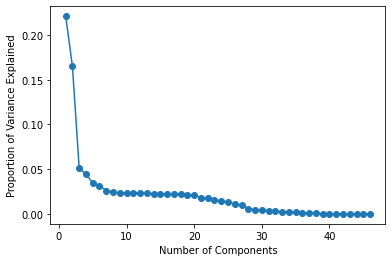

In [95]:
from sklearn.preprocessing import StandardScaler
# Load the data and scale it to have zero mean and unit variance
to_apply_pca = ypet_intensity_processed.drop(pca_excluded, axis = 1)
PCA_testdata= StandardScaler().fit_transform(to_apply_pca)

# Create a PCA object and fit it to the scaled data
pca = PCA()
pca.fit(PCA_testdata)

# Get the explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance ratio
plt.plot(range(1, len(explained_variance)+1), explained_variance, '-o')
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance Explained')
plt.show()

## Find optimal number of clusters with silhouette method

In [91]:
from sklearn.metrics import silhouette_score

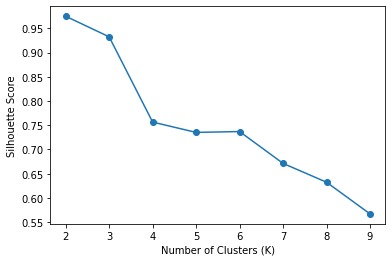

In [96]:
# Load the data
to_apply_pca = ypet_intensity_processed.drop(pca_excluded, axis = 1)
X = to_apply_pca
# Create a list of values for K
K = range(2, 10)

# Store the silhouette scores for each value of K
silhouette_scores = []

# Loop over the values of K
for k in K:
    # Create a KMeans model with k clusters
    kmeans = KMeans(n_clusters=k)
    
    # Fit the model to the data
    kmeans.fit(X)
    
    # Compute the silhouette score for the model
    silhouette_score_k = silhouette_score(X, kmeans.labels_)
    
    # Append the silhouette score to the list
    silhouette_scores.append(silhouette_score_k)

# Plot the silhouette scores
plt.plot(K, silhouette_scores, '-o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

### Apply a principal component analysis (PCA) and prepare dataframe for clustering

In [28]:
pca = PCA(n_components)

# define which columns should be excluded
to_apply_pca = ypet_intensity_processed.drop(pca_excluded, axis = 1)

# Check how much variance the PCA components explain
pca_result = pca.fit(to_apply_pca)
print(pca_result.explained_variance_ratio_)

# apply the dimensionality reduction on data
pca_components = pca.fit_transform(to_apply_pca)

# Combine excluded data and pca
ypet_intensity_pca = ypet_intensity_processed[pca_excluded]
for iter_i in range(n_components):
    name = 'pca_component_' + str(iter_i)
    ypet_intensity_pca[name] = pca_components[:,iter_i]

[0.75536267 0.16556735 0.0790698 ]


C:\Users\Sophia\AppData\Local\Temp\ipykernel_11720\1602241279.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ypet_intensity_pca[name] = pca_components[:,iter_i]
C:\Users\Sophia\AppData\Local\Temp\ipykernel_11720\1602241279.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ypet_intensity_pca[name] = pca_components[:,iter_i]
C:\Users\Sophia\AppData\Local\Temp\ipykernel_11720\1602241279.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [30]:
ypet_cluster = ypet_intensity_pca.reset_index().set_index(['index','patch','img','TF_name'])


### Apply Kmean clustering algorithm

In [53]:
#apply KMeans algorithm
kmean = KMeans(n_clusters=n_clusters, random_state=random_state).fit(ypet_cluster)

#save as new dataframe and add column for clustering label
ypet_clustered = ypet_cluster.copy()
ypet_clustered['cluster'] = kmean.labels_

In [54]:
ypet_clustered

,,,,pca_component_0,pca_component_1,pca_component_2,cluster
index,patch,img,TF_name,,,,
0,patch_20,1,A - 1,352690.910007,-1.499391e+06,-92889.024336,11
1,patch_21,1,A - 1,-103973.380386,-6.051072e+05,-77260.044455,5
2,patch_22,1,A - 1,-531469.080349,6.682542e+05,-74271.240887,0
3,patch_23,1,A - 1,-472737.420285,1.301960e+06,-96265.085313,0
4,patch_24,1,A - 1,-542986.188521,8.196412e+05,-77315.897520,0
...,...,...,...,...,...,...,...
1276,patch_1309,12,B - 1,-806415.239674,1.395089e+06,-23639.062117,0
1277,patch_1310,12,B - 1,-709869.833164,1.080379e+06,-31742.206675,0
1278,patch_1311,12,B - 1,-736977.125579,1.172866e+06,-19435.333745,0


### Visualization of the results

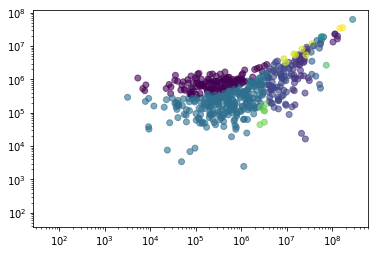

In [97]:
if n_components <2:
    print("Careful, only the first two dimensions are plotted. You're df has more dimension")

plt.figure()
plt.scatter(ypet_cluster.iloc[:,0], ypet_cluster.iloc[:,1], c=kmean.labels_, alpha=0.6)
plt.yscale('log')
plt.xscale('log')
plt.show()

### Analysis of the results

In [55]:
ypet_clustered = ypet_clustered.reset_index()

In [81]:
# Check how many points are in which cluster
spread = ypet_clustered.groupby(['TF_name', 'cluster']).count()
spread = spread.rename(columns={'index': 'n_points'})
spread = spread.drop(columns=spread.columns[1:], axis = 1)
spread

n_points
TF_name cluster          
A - 1   0            2595
        1               1
        2              24
        3              50
        4              12
...                   ...
D - 8   0            6583
        3               3
        5            1215
        9               1
        11             62

[97 rows x 1 columns]

In [83]:
spread.groupby('TF_name').var()

,n_points
TF_name,
A - 1,9.313769e+05
B - 1,7.725245e+05
B - 10,6.496023e+05
B - 11,1.590350e+05
B - 12,5.362857e+04
B - 2,5.052878e+04
B - 3,2.566049e+04
B - 4,4.900000e+01
B - 5,6.253300e+04


In [44]:
# data_ratio, indicating how similar one TF is clustered
data_ratio = pd.DataFrame(columns = ['TF_name','total_tf','max_clust','ratio_same_clust'])
data_ratio['TF_name'] = [tf for tf in np.unique(ypet_clustered['TF_name'])]
data_ratio['total_tf'] = [np.sum(ypet_clustered['TF_name']==tf) for tf in np.unique(ypet_clustered['TF_name'])]
data_ratio['max_clust'] = [max([len(ypet_clustered[(ypet_clustered['cluster'] == i) & (ypet_clustered['TF_name'] == tf)]) for i in range(n_clusters)]) for tf in np.unique(ypet_clustered['TF_name'])]
data_ratio['ratio_same_clust'] = data_ratio['max_clust']/data_ratio['total_tf']
data_ratio



,TF_name,total_tf,max_clust,ratio_same_clust
0,A - 1,4,2,0.5


In [84]:
round(data_ratio.ratio_same_clust.mean(),3)

0.5

In [85]:
cluster_point = ypet_clustered.groupby('cluster').count()
cluster_point = cluster_point.rename(columns={'index': 'n_points'})
cluster_point = cluster_point.drop(columns=cluster_point.columns[1:], axis = 1)
cluster_point

,n_points
cluster,
0,20315
1,5
2,89
3,275
4,23
5,8509
6,1
7,2
8,112


In [ ]:
# Extract x percentage of data per cluster -> For further analysation
extracted_i = []
x = 0.9

for i in range(n_clusters):

    # indices of all the points from X that belong to cluster i
    C_i = np.where(kmean.labels_ == i)[0].tolist() 
    n_i = len(C_i) # number of points in cluster i

    # indices of the points from X to be sampled from cluster i
    sample_i = np.random.choice(C_i, math.ceil((x * n_i))).tolist()
    extracted_i.extend(sample_i) 
    
ypet_clustered.iloc[np.unique(extracted_i)]
    

,index,patch,img,TF_name,pca_component_0,pca_component_1,pca_component_2,cluster
0,0,patch_28,1,B - 12,3.668233e+05,-1.567035e+06,766199.028033,8
1,1,patch_29,1,B - 12,6.841009e+04,-3.496970e+05,331411.467403,1
2,2,patch_30,1,B - 12,1.392316e+05,-1.617002e+05,-27966.915010,1
5,5,patch_33,1,B - 12,6.277760e+05,-1.743506e+06,979056.509353,8
6,6,patch_34,1,B - 12,7.388573e+05,-1.637174e+06,815208.434862,8
...,...,...,...,...,...,...,...,...
13033,1272,patch_1305,12,B - 1,-1.067936e+06,1.122563e+06,-652021.851667,6
13034,1273,patch_1306,12,B - 1,-9.685735e+05,8.944489e+05,-544822.847997,6
13035,1274,patch_1307,12,B - 1,-1.097020e+06,1.179466e+06,-688304.559240,6
13039,1278,patch_1311,12,B - 1,-1.050063e+06,1.075155e+06,-635266.654554,6
